In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import data
from models import INN_AA
from utils import config


def tensor2imgs(t, n=8):
    imgrid = torchvision.utils.make_grid(t, n)
    return imgrid.data.mul(255).clamp(0, 255).byte().cpu().numpy()

c = config.Config()
# c.load("./runs/Oct23_01-37-19_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_01-26-04_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_01-39-52_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_02-52-36_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Sep03_23-38-37_GLaDOS_INN_AA/checkpoints/config.toml")
c.load("./runs/Dec22_23-45-54_GLaDOS_INN_AA/checkpoints/config.toml")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST(
        "~/Data",
        split="digits",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.permute(0, 2, 1)),
            ]
        ),
    ),
    batch_size=512,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST(
        "~/Data",
        split="digits",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.permute(0, 2, 1)),
            ]
        ),
    ),
    batch_size=512,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)
letter_loader = torch.utils.data.DataLoader(
    datasets.EMNIST(
        "~/Data",
        split="letters",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.permute(0, 2, 1)),
            ]
        ),
    ),
    batch_size=512,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)
fashion_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "~/Data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.permute(0, 2, 1)),
            ]
        ),
    ),
    batch_size=512,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)
kmnist_loader = torch.utils.data.DataLoader(
    datasets.KMNIST(
        "~/Data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            ]
        ),
    ),
    batch_size=512,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)

In [18]:
c = config.Config()
# c.load("./runs/Oct23_01-37-19_GLaDOS_INN_AA/checkpoints/config.toml")
c.load("./runs/Dec09_01-26-04_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_01-39-52_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_02-52-36_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Sep03_23-38-37_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec22_23-45-54_GLaDOS_INN_AA/checkpoints/config.toml")

model = INN_AA(**c.__dict__)
# model.load("./runs/Oct23_01-37-19_GLaDOS_INN_AA/checkpoints/INN_AA_490.pt")
model.load("./runs/Dec09_01-26-04_GLaDOS_INN_AA/checkpoints/INN_AA_300.pt")
# model.load("./runs/Dec09_01-39-52_GLaDOS_INN_AA/checkpoints/INN_AA_300.pt")
# model.load("./runs/Dec09_02-52-36_GLaDOS_INN_AA/checkpoints/INN_AA_300.pt")
# model.load("./runs/Sep03_23-38-37_GLaDOS_INN_AA/checkpoints/INN_AA.pt")
# model.load("./runs/Dec22_23-45-54_GLaDOS_INN_AA/checkpoints/INN_AA_700.pt")
model.to('cuda')
print()

In [4]:
with torch.no_grad():
    latent_codes = torch.empty(0, c.latent_dim)
    all_labels = torch.empty(0, dtype=torch.long)
    all_z = torch.empty(0, c.latent_dim)
    for samples, labels in tqdm(data.get_dataset("FERG_expressions", leave=False):
        samples, labels = samples.to(device), labels.to(device)
        t, A, B = model(samples, model.labels2condition(labels))
        if c.interpolation == "linear":
            latent_codes = torch.cat(
                [latent_codes, (A @ model.z_arch).cpu()], dim=0
            )
        elif c.interpolation == "slerp":
            A_ = torch.sin(A * np.pi * 2 / 3)
            latent_codes = torch.cat(
                [
                    latent_codes,
                    (
                        A_ @ model.z_arch / np.sin(np.pi * 2 / 3)
                    ).cpu(),
                ],
                dim=0,
            )
        all_labels = torch.cat([all_labels, labels.cpu()], dim=0)
        all_z = torch.cat([all_z, (B @ A @ model.z_arch).cpu()], dim=0)

        
    kmeans = KMeans(n_clusters=3).fit(all_z)
    fig, ax = plt.subplots()
#     img = ax.scatter(
#         latent_codes[:, 0],
#         latent_codes[:, 1],
#         alpha=0.4,
#         c=all_labels,
#         cmap="tab10",
#         vmin=0,
#         vmax=9,
#     )

    ax.scatter(
        all_z[:, 0].cpu(),
        all_z[:, 1].cpu(),
        marker="x",
        s=100,
        c="r",
    )
    ax.scatter(
        model.z_arch[:, 0].cpu(),
        model.z_arch[:, 1].cpu(),
        marker="x",
        s=100,
        c="k",
    )
    ax.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        marker="x",
        s=100,
        c="b",
    )
ax.set_aspect("equal")
fig.colorbar(img)
fig.show()

SyntaxError: invalid syntax (<ipython-input-4-85aab953a449>, line 5)

RuntimeError: start (0) + length (6) exceeds dimension size (4).

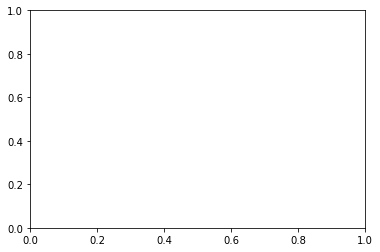

In [5]:
with torch.no_grad():
    fig, ax = plt.subplots()
    for i in range(1):

        latent_codes = torch.empty(0, c.latent_dim)
        all_labels = torch.empty(0, dtype=torch.long)
        all_z = torch.empty(0, c.latent_dim)
        for samples, labels in tqdm(letter_loader, leave=False):
            samples, labels_l = samples.to(device), labels.to(device)
            samples = samples[labels_l == 9]
            labels_l = labels_l[labels_l == 9]
            labels = 1 * torch.ones_like(labels_l, device='cuda')
            t, A, B = model(samples, model.labels2condition(labels))
            if c.interpolation == "linear":
                latent_codes = torch.cat(
                    [latent_codes, (A @ model.z_arch).cpu()], dim=0
                )
            elif c.interpolation == "slerp":
                A_ = torch.sin(A * np.pi * 2 / 3)
                latent_codes = torch.cat(
                    [
                        latent_codes,
                        (
                            A_ @ model.z_arch / np.sin(np.pi * 2 / 3)
                        ).cpu(),
                    ],
                    dim=0,
                )
            all_labels = torch.cat([all_labels, labels.cpu()], dim=0)

            all_z = torch.cat([all_z, (B @ A @ model.z_arch).cpu()], dim=0)


    #     img = ax.scatter(
    #         latent_codes[:, 0],
    #         latent_codes[:, 1],
    #         alpha=0.4,
    #         c=all_labels,
    #         cmap="tab10",
    #         vmin=0,
    #         vmax=9,
    #     )

        kmeans = KMeans(n_clusters=3).fit(all_z)
    
        ax.scatter(
            all_z[:, 0].cpu(),
            all_z[:, 1].cpu(),
            marker="x",
            s=100,
            c="r",
        )
        ax.scatter(
            kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            marker="x",
            s=100,
            c="b",
        )
    ax.scatter(
        model.z_arch[:, 0].cpu(),
        model.z_arch[:, 1].cpu(),
        marker="x",
        s=100,
        c="k",
    )
ax.set_aspect("equal")
fig.colorbar(img)
fig.show()

In [ ]:
with torch.no_grad():
    latent_codes = torch.empty(0, c.latent_dim)
    all_labels = torch.empty(0, dtype=torch.long)
    all_z = torch.empty(0, c.latent_dim)
    for samples, labels in tqdm(train_loader, leave=False):
        samples, labels = samples.to(device), labels.to(device)
        t, A, B = model(samples, model.labels2condition(labels))
        A = A + 0.03 * torch.randn_like(A)
        if c.interpolation == "linear":
            latent_codes = torch.cat(
                [latent_codes, (A @ model.z_arch).cpu()], dim=0
            )
        elif c.interpolation == "slerp":
            A_ = torch.sin(A * np.pi * 2 / 3)
            latent_codes = torch.cat(
                [
                    latent_codes,
                    (
                        A_ @ model.z_arch / np.sin(np.pi * 2 / 3)
                    ).cpu(),
                ],
                dim=0,
            )
        all_labels = torch.cat([all_labels, labels.cpu()], dim=0)
        all_z = torch.cat([all_z, (B @ A @ model.z_arch).cpu()], dim=0)
        
        
    z_arch_sample = torch.empty(0, c.latent_dim)
    for i in range(10):
        dist = torch.norm(latent_codes[all_labels == i][:, None, :] - model.z_arch[None, ...].cpu(), dim=-1)
        sample = torch.stack([
            latent_codes[all_labels == i][torch.argmin(dist[:, j])] for j in range(model.z_arch.shape[0])
        ], dim=0)
#         print(sample.shape)
        z_arch_sample = torch.cat([z_arch_sample, sample], dim=0)
        
    z_arch_sample = model.inn.sample(model.layers_C(z_arch_sample.cuda()), model.labels2condition(torch.tensor(range(10), device=device).repeat_interleave(3))).cpu()
        
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    img = axes[0].scatter(
        latent_codes[:, 0],
        latent_codes[:, 1],
        alpha=0.4,
        c=all_labels,
        cmap="tab10",
        vmin=0,
        vmax=9,
    )

    axes[0].scatter(
        model.z_arch[:, 0].cpu(),
        model.z_arch[:, 1].cpu(),
        marker="x",
        s=100,
        c="k",
    )
    
    axes[1].imshow(tensor2imgs(z_arch_sample, 3).transpose(1, 2, 0))
    
axes[0].set_aspect("equal")
fig.colorbar(img, ax=axes[0])
fig.show()

torch.Size([1000, 2])


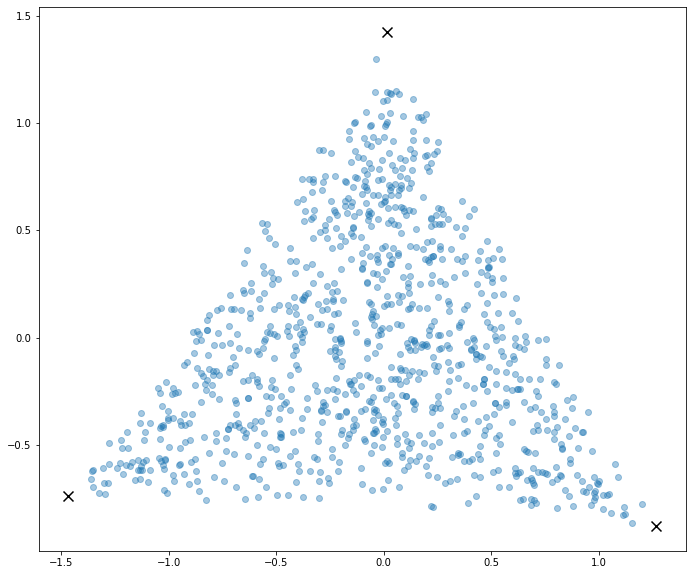

In [6]:
with torch.no_grad():
    fig, axes = plt.subplots(figsize=(20, 10))

    A = torch.randn(1000, 3)
    A = torch.exp(A)/torch.sum(torch.exp(A), dim=1, keepdim=True)
#     A = A + 0.1* torch.randn_like(A)
    latent_codes = A @ model.z_arch.cpu()

    print(latent_codes.shape)

    img = axes.scatter(
        latent_codes[:, 0],
        latent_codes[:, 1],
        alpha=0.4,
    )

    axes.scatter(
        model.z_arch[:, 0].cpu(),
        model.z_arch[:, 1].cpu(),
        marker="x",
        s=100,
        c="k",
    )
    axes.set_aspect("equal")

In [15]:
%matplotlib inline
import ipywidgets as widgets
import torchvision

import data
from models import INN_AA
from utils import config

from scipy.stats import dirichlet
import matplotlib.tri as tri
 Aug18_16-34-03_GLaDOS_INN 


def tensor2imgs(t, n=8):
    imgrid = torchvision.utils.make_grid(t, n)
    return imgrid.data.mul(255).clamp(0, 255).byte().cpu().numpy()


# c = config.Config()
# c.load("./runs/Oct23_01-37-19_GLaDOS_INN_AA/checkpoints/config.toml")

# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = INN_AA(**c.__dict__)
# model.load("./runs/Oct23_01-37-19_GLaDOS_INN_AA/checkpoints/INN_AA_490.pt")
# model.to("cuda")

fixed_cond_z = model.labels2condition(
    torch.tensor(range(c.n_classes), device=device).repeat_interleave(c.n_classes)
)

dim = 2
# print(list(np.arange(0.02, 1, 0.02)) + list(np.arange(1, 3, 0.1)))


@widgets.interact(
    s=widgets.SelectionSlider(
        options=list(np.arange(0.02, 1, 0.02).round(2)) + list(np.arange(1, 8, 0.1).round(2)),
        value=1,
        layout=widgets.Layout(width='512px'),
        readout_format='.2f',
        readout=True,
        continuous_update=False,
    )
)
def plot_sample(s):
    #     print(s)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    dim = 2
    # z = build_z_simplex(dim, False)
#     z = build_z_simplex1(dim, False)
    z = model.z_arch.cpu().detach().numpy()

    # print(z)

    # z -= z.mean()
    # z *= np.sqrt(1+1/dim)
    # A = np.exp(np.random.randn(100000, dim + 1))
    A = np.random.dirichlet(s * np.ones(dim + 1), 1000)
    A = A / A.sum(axis=1, keepdims=True)
    r = A @ z
    with torch.no_grad():
        samples, _ = model.sample(
            torch.tensor(A[:(c.n_classes * c.n_classes)], device=device, dtype=torch.float), fixed_cond_z
        )

#     print(samples.shape)
    triangle = tri.Triangulation(z[:, 0], z[:, 1])


    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)
    t = Delaunay(z)
    p = np.stack((trimesh.x, trimesh.y), axis=1)
    b = t.transform[0,:2].dot(np.transpose(p - t.transform[0,2]))

    b = np.clip(np.c_[np.transpose(b), 1 - b.sum(axis=0)], 1e-16, 1)
    pvals = [dirichlet.pdf(x, s*np.ones(dim + 1)) for x in b]

    tcm = axes[0].tricontourf(trimesh, pvals, 200, cmap='plasma', alpha=1)

    axes[0].scatter(r[:, 0], r[:, 1], c='k', alpha=0.1)

    # ax.scatter(0, 0, marker='x', c='r')
    axes[0].set_aspect("equal")
    axes[0].set_xlim((-1.6, 2.2))
    axes[0].set_ylim((-1.6, 2.2))
    fig.colorbar(tcm, ax=axes[0])
    
    axes[1].imshow(data.tensors2image(c.dataset, samples, c.n_classes).transpose(1, 2, 0))
    axes[1].set_axis_off()
    fig.show()

interactive(children=(SelectionSlider(continuous_update=False, description='s', index=49, layout=Layout(width=…

In [16]:
@widgets.interact(
    s1=widgets.SelectionSlider(
        options=list(np.arange(0.02, 1, 0.02).round(2)) + list(np.arange(1, 8, 0.1).round(2)),
        value=1,
        layout=widgets.Layout(width='512px'),
        readout_format='.2f',
        readout=True,
        continuous_update=False,
    ),
    s2=widgets.SelectionSlider(
        options=list(np.arange(0.02, 1, 0.02).round(2)) + list(np.arange(1, 8, 0.1).round(2)),
        value=1,
        layout=widgets.Layout(width='512px'),
        readout_format='.2f',
        readout=True,
        continuous_update=False,
    ),
    s3=widgets.SelectionSlider(
        options=list(np.arange(0.02, 1, 0.02).round(2)) + list(np.arange(1, 8, 0.1).round(2)),
        value=1,
        layout=widgets.Layout(width='512px'),
        readout_format='.2f',
        readout=True,
        continuous_update=False,
    )
)
def plot_sample(s1, s2, s3):
    #     print(s)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    dim = 2
    # z = build_z_simplex(dim, False)
#     z = build_z_simplex1(dim, False)
    z = model.z_arch.cpu().detach().numpy()

    # print(z)

    # z -= z.mean()
    # z *= np.sqrt(1+1/dim)
    # A = np.exp(np.random.randn(100000, dim + 1))
    A = np.random.dirichlet(np.array([s1, s2, s3]), 1000)
    A = A / A.sum(axis=1, keepdims=True)
    # print(np.linalg.norm(A, 1, axis=-1))

    phi = np.linspace(0, 2 * np.pi)
    # ax.plot(np.cos(phi), np.sin(phi))
    with torch.no_grad():
        samples, _ = model.sample(
            torch.tensor(A[:(c.n_classes * c.n_classes)], device=device, dtype=torch.float), fixed_cond_z
        )

        
        triangle = tri.Triangulation(z[:, 0], z[:, 1])


    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)
    t = Delaunay(z)
    p = np.stack((trimesh.x, trimesh.y), axis=1)
    b = t.transform[0,:2].dot(np.transpose(p - t.transform[0,2]))

    b = np.clip(np.c_[np.transpose(b), 1 - b.sum(axis=0)], 1e-16, 1)
    pvals = [dirichlet.pdf(x, np.array([s1, s2, s3])) for x in b]

    tcm = axes[0].tricontourf(trimesh, pvals, 200, cmap='plasma', alpha=1)
    
    t = A @ z
    axes[0].scatter(t[:, 0], t[:, 1], c='k', alpha=0.1)
    # ax.scatter(z[:, 0], z[:, 1], marker='o', c='r', alpha=0.2)
    axes[0].scatter(z[:, 0], z[:, 1], marker="x", c="r", alpha=1)

    # ax.scatter(0, 0, marker='x', c='r')
    axes[0].set_aspect("equal")
    axes[0].set_xlim((-1.6, 2.2))
    axes[0].set_ylim((-1.6, 2.2))

    axes[1].imshow(data.tensors2image(c.dataset, samples, c.n_classes).transpose(1, 2, 0))
    axes[1].set_axis_off()
    fig.show()

interactive(children=(SelectionSlider(continuous_update=False, description='s1', index=49, layout=Layout(width…

In [10]:
c = config.Config()
# c.load("./runs/Oct23_01-37-19_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_01-26-04_GLaDOS_INN_AA/checkpoints/config.toml")
# c.load("./runs/Dec09_01-39-52_GLaDOS_INN_AA/checkpoints/config.toml")
c.load("./runs/Sep03_23-38-37_GLaDOS_INN_AA/checkpoints/config.toml")